Upload pneumothorax.zip and the model to the notebook

In [0]:
!curl ipecho.net/plain
#make sure your ip address isn't located in China or something

35.193.98.43

In [0]:
!pip install tensorflow-io

In [0]:
#loading dependencies

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio

In [0]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [0]:
!unzip /content/pnemothorax.zip

In [0]:
train_filenames_df = pd.read_csv('/content/pneumothorax/training.csv')

In [0]:
@tf.function
def process_image(file_path):
  img = tf.io.read_file(file_path)
  img = tfio.image.decode_dicom_image(img, dtype=tf.float32)
  img = tf.image.per_image_standardization(img)
  img = tf.image.resize(img, (256,256))
  img = tf.reshape(img,(256,256,1))
  img = tf.squeeze(img)
  img = tf.expand_dims(img, -1)
  return img
@tf.function
def process_mask(file_path):
  mask = tf.io.read_file(file_path)
  mask = tf.io.decode_png(mask,channels=1)
  mask = tf.image.transpose(mask)
  mask = tf.image.resize(mask, (256,256))
  mask = tf.reshape(mask, (256,256,1))
  mask = tf.cast(mask, tf.float32)
  return mask

#Loading and preparing the example dataset sourced from Kaggle https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data

X_train_ds = tf.data.Dataset.from_tensor_slices(train_filenames_df['dicom_filepath'])
Y_train_ds = tf.data.Dataset.from_tensor_slices(train_filenames_df['mask_png_filepath'])

X_train_ds = X_train_ds.map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
Y_train_ds = Y_train_ds.map(process_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_ds = tf.data.Dataset.zip((X_train_ds, Y_train_ds))
train_ds = train_ds.batch(16).prefetch(1).repeat()

In [0]:
train_ds_iter = iter(train_ds)

In [0]:
#insert the filepath for the .hdf5 model into the load_model method

model = tf.keras.models.load_model('/content/model.10-0.0076718518.hdf5')

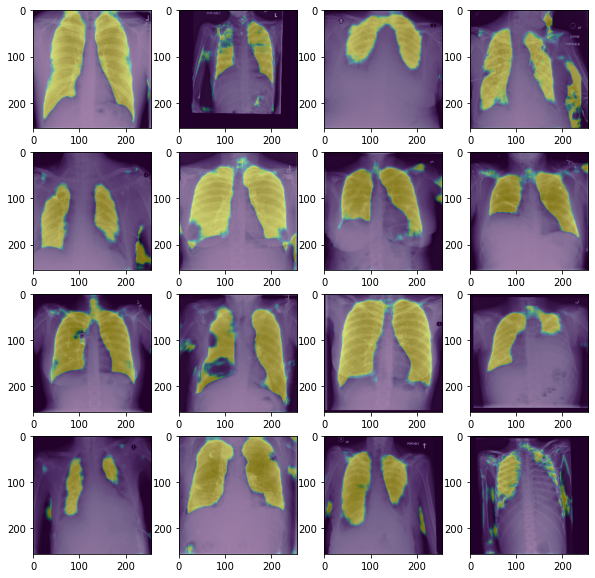

In [0]:
#displaying results overlayed on the example dataset
#run cell multiple times for more examples

import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 4, figsize=(10,10))
flatten = lambda l: [item for sublist in l for item in sublist]

x, y = next(train_ds_iter)
z = model.predict(x)

for i, axis in enumerate(flatten(axes)):
  axis.imshow(tf.squeeze(x[i]), cmap=plt.cm.bone)
  axis.imshow(tf.squeeze(z[i]), alpha=0.5)